In [35]:
# installing libraries
# !pip install yellowbrick

In [1]:
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import datetime
import warnings
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from yellowbrick.cluster import KElbowVisualizer
from sklearn.preprocessing import StandardScaler
warnings.filterwarnings("ignore")

In [2]:
# loading the dataset
file_path = '/content/drive/MyDrive/Job Hunt/Customer/RFM segmentation/online_retail_II.xlsx'
data = pd.read_excel(file_path,sheet_name="Year 2010-2011")
data.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541910 entries, 0 to 541909
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Invoice      541910 non-null  object        
 1   StockCode    541910 non-null  object        
 2   Description  540456 non-null  object        
 3   Quantity     541910 non-null  int64         
 4   InvoiceDate  541910 non-null  datetime64[ns]
 5   Price        541910 non-null  float64       
 6   Customer ID  406830 non-null  float64       
 7   Country      541910 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [4]:
data[['Quantity','Price']].describe()

,Quantity,Price
count,541910.000000,541910.000000
mean,9.552234,4.611138
std,218.080957,96.759765
min,-80995.000000,-11062.060000
25%,1.000000,1.250000
50%,3.000000,2.080000
75%,10.000000,4.130000
max,80995.000000,38970.000000


There are some negative values as well in this price, we clean that too.

##Data cleaning

In [5]:
# Finding number of distinct invoices and number of distinct customer
data['Invoice'].nunique(),data['Customer ID'].nunique()

(25900, 4372)

There are 25900 distinct invoices and 4372 distinct customer.

In [6]:
# finding the total number of rows which is having 'C' invoice
data["Invoice"].str.contains("C", na=False).sum()

9288

In [7]:
# finding the total number of distinct rows which is having 'C' invoice
data[data["Invoice"].str.contains("C", na=False)]["Invoice"].nunique()

3836

In [8]:
# removing 'C'
data["Invoice"] = data["Invoice"].astype(str).replace('C', '', regex=True)

In [9]:
data.isnull().sum()

Invoice             0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
Price               0
Customer ID    135080
Country             0
dtype: int64

In [10]:
# deleting the null values
data.dropna(inplace=True)

In [11]:
data = data[data["Quantity"] > 0]
data = data[data["Price"] > 0]

In [12]:
# Finding new number of distinct invoices and number of distinct customer
data['Invoice'].nunique(),data['Customer ID'].nunique()

(18532, 4338)

## Customer Segmentation using RFM

In [13]:
# Amount spent
data["TotalPrice"] = data["Quantity"] * data["Price"]

In [16]:
# Get today's date
today_date = datetime.date.today()
rfm = data.groupby("Customer ID").agg({"InvoiceDate": lambda x :(today_date-x.max().date()).days,
                               "Invoice": lambda x : x.nunique(),
                               "TotalPrice":lambda x : x.sum()})
rfm.head()

,InvoiceDate,Invoice,TotalPrice
Customer ID,,,
12346.0,4622,1,77183.60
12347.0,4299,7,4310.00
12348.0,4372,4,1797.24
12349.0,4315,1,1757.55
12350.0,4607,1,334.40


In [17]:
rfm = rfm.rename(columns={"InvoiceDate": "recency", "Invoice": "frequency", "TotalPrice": "monetary"})

In [18]:
rfm["receny_score"] = pd.qcut(rfm["recency"],5,labels=[5,4,3,2,1])

rfm["frequency_score"] = pd.qcut(rfm["frequency"].rank(method="first"),5,labels=[1,2,3,4,5])

rfm["monetary_score"] = pd.qcut(rfm["monetary"],5,labels=[1,2,3,4,5])

rfm["rfm_score"]=rfm["receny_score"].astype("str")+rfm["frequency_score"].astype("str")

rfm.head()


,recency,frequency,monetary,receny_score,frequency_score,monetary_score,rfm_score
Customer ID,,,,,,,
12346.0,4622,1,77183.60,1,1,5,11
12347.0,4299,7,4310.00,5,5,5,55
12348.0,4372,4,1797.24,2,4,4,24
12349.0,4315,1,1757.55,4,1,4,41
12350.0,4607,1,334.40,1,1,2,11


In [39]:
seg_map = {
    r'[1-2][1-2]': 'hibernating',
    r'[1-2][3-4]': 'at_Risk',
    r'[1-2]5': 'cant_loose',
    r'3[1-2]': 'about_to_sleep',
    r'33': 'need_attention',
    r'[3-4][4-5]': 'loyal_customers',
    r'41': 'promising',
    r'51': 'new_customers',
    r'[4-5][2-3]': 'potential_loyalists',
    r'5[4-5]': 'champions'
}


rfm['RFM_segment'] = rfm['rfm_score'].replace(seg_map, regex=True)

rfm.reset_index()
rfm.head()


,index,Customer ID,recency,frequency,monetary,receny_score,frequency_score,monetary_score,rfm_score,RFM_segment
0,0,12346.0,4622,1,77183.60,1,1,5,11,hibernating
1,1,12347.0,4299,7,4310.00,5,5,5,55,champions
2,2,12348.0,4372,4,1797.24,2,4,4,24,at_Risk
3,3,12349.0,4315,1,1757.55,4,1,4,41,promising
4,4,12350.0,4607,1,334.40,1,1,2,11,hibernating


In [38]:
df_rfm = rfm[['recency','frequency','monetary']]

sc = MinMaxScaler((0, 1))
df_rfm = sc.fit_transform(df_rfm)

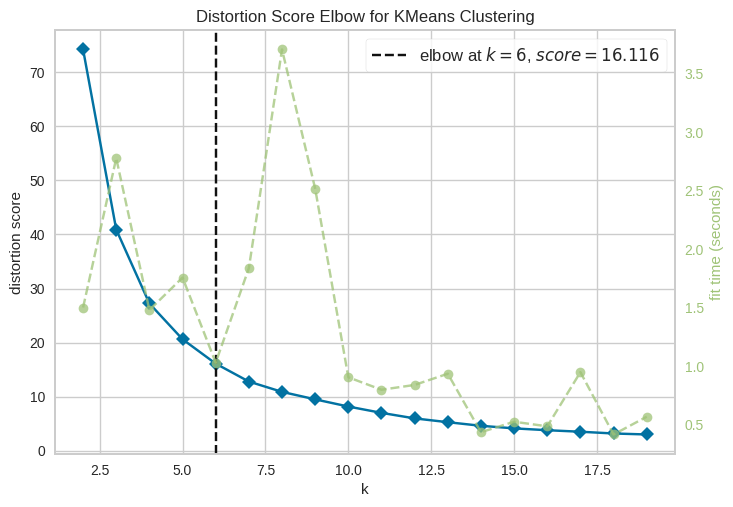

6

In [21]:
kmeans = KMeans()
elbow = KElbowVisualizer(kmeans,k=(2, 20))
elbow.fit(df_rfm)
elbow.show()

In [22]:
optimal_k = elbow.elbow_value_

kmeans = KMeans(n_clusters=elbow.elbow_value_).fit(df_rfm)

kmeans.cluster_centers_

array([[0.0146336 , 0.33253205, 0.31405968],
       [0.66712608, 0.00216685, 0.00211566],
       [0.19697423, 0.00813251, 0.00376146],
       [0.90059093, 0.0017301 , 0.00231617],
       [0.04859184, 0.02324187, 0.00847523],
       [0.43225887, 0.00534809, 0.00265151]])

In [23]:
df_rfm = rfm[['recency','frequency','monetary']]
df_rfm["KMeans_Segment"] = kmeans.labels_
df_rfm.head()

,recency,frequency,monetary,KMeans_Segment
Customer ID,,,,
12346.0,4622,1,77183.60,3
12347.0,4299,7,4310.00,4
12348.0,4372,4,1797.24,2
12349.0,4315,1,1757.55,4
12350.0,4607,1,334.40,3


In [ ]:
df_rfm["KMeans_Segment"].value_counts()

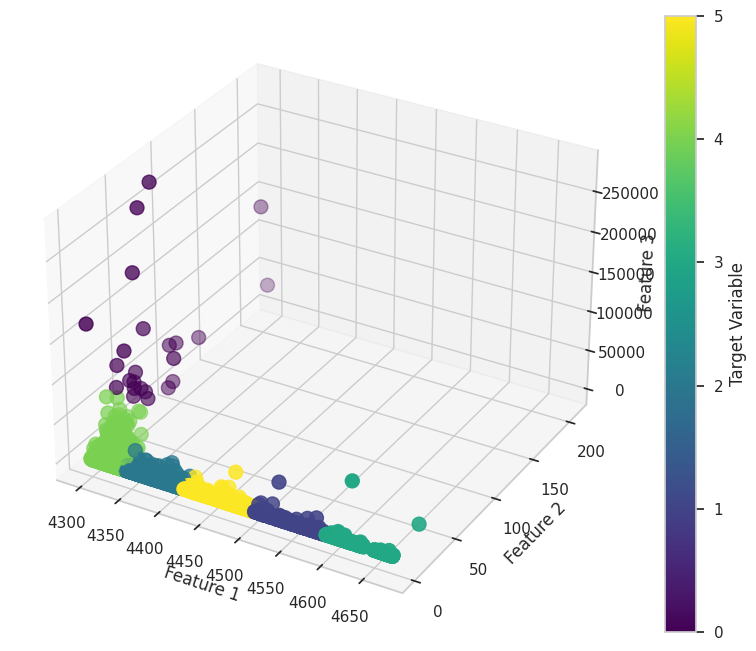

In [31]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot with color coding by target variable
scatter = ax.scatter(df_rfm['recency'], df_rfm['frequency'], df_rfm['monetary'], c=df_rfm['KMeans_Segment'], cmap='viridis', s=100)

ax.set_xlabel('Feature 1')
ax.set_ylabel('Feature 2')
ax.set_zlabel('Feature 3')

# Add colorbar
plt.colorbar(scatter, label='Target Variable')

plt.show()


In [40]:
# Create a mapping of segments to numerical values
segment_mapping = {
    'hibernating': 1,
    'at_Risk': 2,
    'cant_loose': 3,
    'about_to_sleep': 4,
    'need_attention': 5,
    'loyal_customers': 6,
    'promising': 7,
    'new_customers': 8,
    'potential_loyalists': 9,
    'champions': 10
}

# Replace segments with numerical values
rfm['RFM_segment'] = rfm['RFM_segment'].replace(segment_mapping,regex=True)

# Reset the index
rfm.reset_index(inplace=True)

# Print the modified DataFrame
rfm.head()

,level_0,index,Customer ID,recency,frequency,monetary,receny_score,frequency_score,monetary_score,rfm_score,RFM_segment
0,0,0,12346.0,4622,1,77183.60,1,1,5,11,1
1,1,1,12347.0,4299,7,4310.00,5,5,5,55,10
2,2,2,12348.0,4372,4,1797.24,2,4,4,24,2
3,3,3,12349.0,4315,1,1757.55,4,1,4,41,7
4,4,4,12350.0,4607,1,334.40,1,1,2,11,1


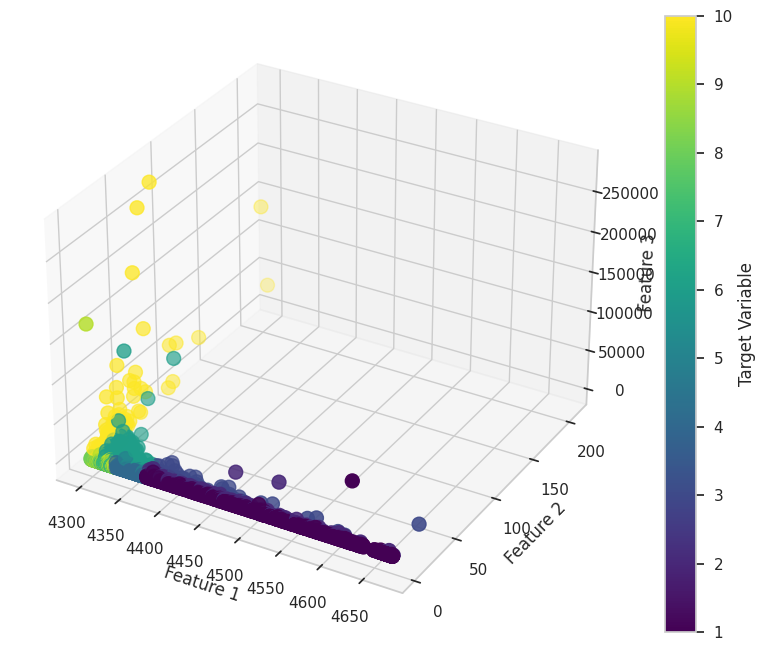

In [41]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot with color coding by target variable
scatter = ax.scatter(rfm['recency'], rfm['frequency'], rfm['monetary'], c=rfm['RFM_segment'], cmap='viridis', s=100)

ax.set_xlabel('Feature 1')
ax.set_ylabel('Feature 2')
ax.set_zlabel('Feature 3')

# Add colorbar
plt.colorbar(scatter, label='Target Variable')

plt.show()


In [42]:
# Count of the rfm cluster, k-means cluster, Aggregation cluster,
# 3 Dataframe, 1st original, 2nd just rfm, 3rd k-means clustering (df_rfm)

# For more experimentation, use this rfm score technique and compare k-means cluster with it
# https://www.youtube.com/watch?v=D-B3WFW3ofw